## FACE IMAGE INPAINTING
### Восстановление фоторграфий, содержащих лица людей

### План работы:
1. Создание метрики FID
2. Обчучение модели DCGAN
3. Оценка полученной модели с помощью FID
4. Подготовка тестовых данныъ
5. Выбор метода восстановление фотографии
6. Восстановление фотографии

### В работе используется датасет CELEBA, который содержит около 2 тыс. фоторграфий звезд.

In [6]:
from tqdm import tqdm
from torch.autograd import Variable
import numpy
from numpy import cov
from numpy import trace
from numpy import iscomplexobj
from numpy import asarray
from numpy.random import shuffle
from scipy.linalg import sqrtm
from keras.applications.inception_v3 import InceptionV3
from keras.applications.inception_v3 import preprocess_input
from keras.datasets.mnist import load_data
from skimage.transform import resize

In [7]:
#%matplotlib inline
import argparse
import os
import random
import torch
import torch.nn as nn
import torch.nn.parallel
import torch.backends.cudnn as cudnn
import torch.optim as optim
import torch.utils.data
import torchvision.datasets as dset
import torchvision.transforms as transforms
import torchvision.utils as vutils
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from IPython.display import HTML

# Set random seed for reproducibility
manualSeed = 999
#manualSeed = random.randint(1, 10000) # use if you want new results
print("Random Seed: ", manualSeed)
random.seed(manualSeed)
torch.manual_seed(manualSeed)

Random Seed:  999


### Создание метрики FID
FID будет рассчитываться на основе модели InceptionV3

In [8]:
# prepare the inception v3 model
model = InceptionV3(include_top=False, pooling='avg', input_shape=(75,75,3))

87916544/87910968 [==============================] - 1s 0us/step


In [9]:
# scale an array of images to a new size
def scale_images(images, new_shape):
    images_list = list()
    for image in images:
        # resize with nearest neighbor interpolation
        new_image = resize(image, new_shape, 0)
        # store
        images_list.append(new_image)
    return asarray(images_list)

# calculate frechet inception distance
def calculate_fid(model, images1, images2):
    # calculate activations
    act1 = model.predict(images1)
    act2 = model.predict(images2)
    # calculate mean and covariance statistics
    mu1, sigma1 = act1.mean(axis=0), cov(act1, rowvar=False)
    mu2, sigma2 = act2.mean(axis=0), cov(act2, rowvar=False)
    # calculate sum squared difference between means
    ssdiff = numpy.sum((mu1 - mu2)**2.0)
    # calculate sqrt of product between cov
    covmean = sqrtm(sigma1.dot(sigma2))
    # check and correct imaginary numbers from sqrt
    if iscomplexobj(covmean):
        covmean = covmean.real
    # calculate score
    fid = ssdiff + trace(sigma1 + sigma2 - 2.0 * covmean)
    return fid

### Предобработка данных

In [10]:
# Number of workers for dataloader
workers = 2

# Batch size during training
batch_size = 128

# Spatial size of training images. All images will be resized to this
#   size using a transformer.
image_size = 64

# Number of channels in the training images. For color images this is 3
nc = 3

# Size of z latent vector (i.e. size of generator input)
nz = 100

# Size of feature maps in generator
ngf = 64

# Size of feature maps in discriminator
ndf = 64

# Number of training epochs
num_epochs = 8

# Learning rate for optimizers
lr = 0.0002

# Beta1 hyperparam for Adam optimizers
beta1 = 0.5

# Number of GPUs available. Use 0 for CPU mode.
ngpu = 1

In [11]:
dataroot = "my_data2"
dataset = dset.ImageFolder(root=dataroot,
                           transform=transforms.Compose([
                               transforms.Resize(image_size),
                               transforms.CenterCrop(image_size),
                               transforms.ToTensor(),
                               transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
                           ]))
# Create the dataloader
dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size,
                                         shuffle=True, num_workers=workers)

In [12]:
batch_X = torch.utils.data.DataLoader(dataset, 
                                        batch_size=batch_size,
                                        shuffle=True)

real_img=[]

for (i,j) in batch_X:
    img=np.array(i)
    real_img.append(img)

In [13]:
real_imgs=[]

for i in range(len(real_img)//128):
    for j in range(128):
            img=np.array(real_img[i][j])
            real_imgs.append(img)

real_imgs=np.array(real_imgs)

real_imgs=np.transpose(real_imgs,(0,3,2,1))
real_imgs = real_imgs.astype('float32')
real_imgs = scale_images(real_imgs, (75,75,3))
real_imgs = preprocess_input(real_imgs)

### Обучение DCGAN

In [14]:
# Decide which device we want to run on
device = torch.device("cuda:0" if (torch.cuda.is_available() and ngpu > 0) else "cpu")


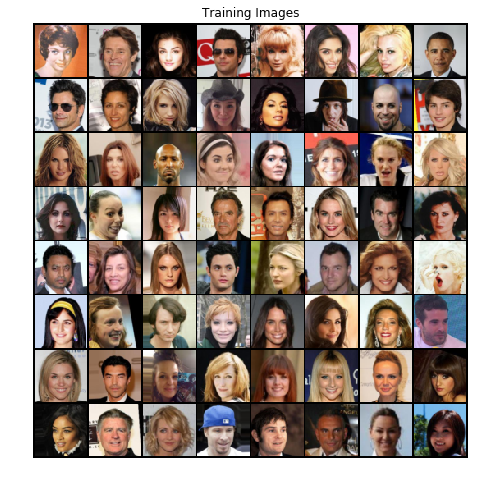

In [15]:
# Plot some training images
real_batch = next(iter(dataloader))
plt.figure(figsize=(8,8))
plt.axis("off")
plt.title("Training Images")
plt.imshow(np.transpose(vutils.make_grid(real_batch[0].to(device)[:64], padding=2, normalize=True).cpu(),(1,2,0)))

In [16]:
# custom weights initialization called on netG and netD
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

In [17]:
# Generator Code

class Generator(nn.Module):
    def __init__(self, ngpu):
        super(Generator, self).__init__()
        self.ngpu = ngpu
        self.main = nn.Sequential(
            # input is Z, going into a convolution
            nn.ConvTranspose2d( nz, ngf * 8, 4, 1, 0, bias=False),
            nn.BatchNorm2d(ngf * 8),
            nn.ReLU(True),
            # state size. (ngf*8) x 4 x 4
            nn.ConvTranspose2d(ngf * 8, ngf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 4),
            nn.ReLU(True),
            # state size. (ngf*4) x 8 x 8
            nn.ConvTranspose2d( ngf * 4, ngf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 2),
            nn.ReLU(True),
            # state size. (ngf*2) x 16 x 16
            nn.ConvTranspose2d( ngf * 2, ngf, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf),
            nn.ReLU(True),
            # state size. (ngf) x 32 x 32
            nn.ConvTranspose2d( ngf, nc, 4, 2, 1, bias=False),
            nn.Tanh()
            # state size. (nc) x 64 x 64
        )

    def forward(self, input):
        return self.main(input)

In [18]:
# Create the generator
netG = Generator(ngpu).to(device)

# Handle multi-gpu if desired
if (device.type == 'cuda') and (ngpu > 1):
    netG = nn.DataParallel(netG, list(range(ngpu)))

# Apply the weights_init function to randomly initialize all weights
#  to mean=0, stdev=0.2.
netG.apply(weights_init)

# Print the model
print(netG)

Generator(
  (main): Sequential(
    (0): ConvTranspose2d(100, 512, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (4): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (7): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU(inplace=True)
    (9): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (10): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): ReLU(inplace=True)
    (12): ConvTranspose2d(64, 3, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (13): Tanh()
  )
)


In [19]:
class Discriminator(nn.Module):
    def __init__(self, ngpu):
        super(Discriminator, self).__init__()
        self.ngpu = ngpu
        self.main = nn.Sequential(
            # input is (nc) x 64 x 64
            nn.Conv2d(nc, ndf, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf) x 32 x 32
            nn.Conv2d(ndf, ndf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 2),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*2) x 16 x 16
            nn.Conv2d(ndf * 2, ndf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 4),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*4) x 8 x 8
            nn.Conv2d(ndf * 4, ndf * 8, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 8),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*8) x 4 x 4
            nn.Conv2d(ndf * 8, 1, 4, 1, 0, bias=False),
            nn.Sigmoid()
        )

    def forward(self, input):
        return self.main(input)

In [20]:
# Create the Discriminator
netD = Discriminator(ngpu).to(device)

# Handle multi-gpu if desired
if (device.type == 'cuda') and (ngpu > 1):
    netD = nn.DataParallel(netD, list(range(ngpu)))

# Apply the weights_init function to randomly initialize all weights
#  to mean=0, stdev=0.2.
netD.apply(weights_init)

# Print the model
print(netD)

Discriminator(
  (main): Sequential(
    (0): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): LeakyReLU(negative_slope=0.2, inplace=True)
    (5): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (6): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): LeakyReLU(negative_slope=0.2, inplace=True)
    (8): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (9): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): LeakyReLU(negative_slope=0.2, inplace=True)
    (11): Conv2d(512, 1, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (12): Sigmoid()
  )
)


In [21]:
# Initialize BCELoss function
criterion = nn.BCELoss()

# Create batch of latent vectors that we will use to visualize
#  the progression of the generator
fixed_noise = torch.randn(64, nz, 1, 1, device=device)

# Establish convention for real and fake labels during training
real_label = 1
fake_label = 0

# Setup Adam optimizers for both G and D
optimizerD = optim.Adam(netD.parameters(), lr=lr, betas=(beta1, 0.999))
optimizerG = optim.Adam(netG.parameters(), lr=lr, betas=(beta1, 0.999))

In [22]:
# Training Loop

# Lists to keep track of progress
img_list = []
G_losses = []
D_losses = []
iters = 0
fids=[]
img_count=100

print("Starting Training Loop...")
# For each epoch
for epoch in range(num_epochs):
    # For each batch in the dataloader
    for i, data in enumerate(dataloader, 0):

        ############################
        # (1) Update D network: maximize log(D(x)) + log(1 - D(G(z)))
        ###########################
        ## Train with all-real batch
        netD.zero_grad()
        # Format batch
        real_cpu = data[0].to(device)
        b_size = real_cpu.size(0)
        label = torch.full((b_size,), real_label, device=device)
        # Forward pass real batch through D
        output = netD(real_cpu).view(-1)
        # Calculate loss on all-real batch
        errD_real = criterion(output, label)
        # Calculate gradients for D in backward pass
        errD_real.backward()
        D_x = output.mean().item()

        ## Train with all-fake batch
        # Generate batch of latent vectors
        noise = torch.randn(b_size, nz, 1, 1, device=device)
        # Generate fake image batch with G
        fake = netG(noise)
        label.fill_(fake_label)
        # Classify all fake batch with D
        output = netD(fake.detach()).view(-1)
        # Calculate D's loss on the all-fake batch
        errD_fake = criterion(output, label)
        # Calculate the gradients for this batch
        errD_fake.backward()
        D_G_z1 = output.mean().item()
        # Add the gradients from the all-real and all-fake batches
        errD = errD_real + errD_fake
        # Update D
        optimizerD.step()

        ############################
        # (2) Update G network: maximize log(D(G(z)))
        ###########################
        netG.zero_grad()
        label.fill_(real_label)  # fake labels are real for generator cost
        # Since we just updated D, perform another forward pass of all-fake batch through D
        output = netD(fake).view(-1)
        # Calculate G's loss based on this output
        errG = criterion(output, label)
        # Calculate gradients for G
        errG.backward()
        D_G_z2 = output.mean().item()
        # Update G
        optimizerG.step()

        # Output training stats
        if i % 50 == 0:
            print('[%d/%d][%d/%d]\tLoss_D: %.4f\tLoss_G: %.4f\tD(x): %.4f\tD(G(z)): %.4f / %.4f'
                  % (epoch, num_epochs, i, len(dataloader),
                     errD.item(), errG.item(), D_x, D_G_z1, D_G_z2))

        # Save Losses for plotting later
        G_losses.append(errG.item())
        D_losses.append(errD.item())

        # Check how the generator is doing by saving G's output on fixed_noise
        if (iters % 500 == 0) or ((epoch == num_epochs-1) and (i == len(dataloader)-1)):
            with torch.no_grad():
                fake = netG(fixed_noise).detach().cpu()
            img_list.append(vutils.make_grid(fake, padding=2, normalize=True))

        iters += 1

    fixed_noise = torch.randn(img_count, nz, 1, 1, device=device)
        
    with torch.no_grad():
        fakes = netG(fixed_noise).detach().cpu()
    
    results = np.array(fakes)
    results = np.transpose(results,(0,3,2,1))
    results = results.astype('float32')
    results = scale_images(results, (75,75,3))
    results = preprocess_input(results)
    
    fid=calculate_fid(model, results, real_imgs)
    fids.append(fid)

Starting Training Loop...
[0/8][0/1583]	Loss_D: 1.8212	Loss_G: 2.0935	D(x): 0.2994	D(G(z)): 0.2659 / 0.1650
[0/8][50/1583]	Loss_D: 0.1159	Loss_G: 11.3145	D(x): 0.9430	D(G(z)): 0.0004 / 0.0000
[0/8][100/1583]	Loss_D: 1.0037	Loss_G: 20.8001	D(x): 0.9925	D(G(z)): 0.5078 / 0.0000
[0/8][150/1583]	Loss_D: 0.2245	Loss_G: 5.2799	D(x): 0.8758	D(G(z)): 0.0253 / 0.0123
[0/8][200/1583]	Loss_D: 1.2046	Loss_G: 4.0425	D(x): 0.4977	D(G(z)): 0.0116 / 0.0343
[0/8][250/1583]	Loss_D: 1.1039	Loss_G: 5.8755	D(x): 0.7421	D(G(z)): 0.3973 / 0.0059
[0/8][300/1583]	Loss_D: 0.3537	Loss_G: 4.0867	D(x): 0.8260	D(G(z)): 0.1033 / 0.0306
[0/8][350/1583]	Loss_D: 0.4924	Loss_G: 3.6829	D(x): 0.7207	D(G(z)): 0.0794 / 0.0388
[0/8][400/1583]	Loss_D: 0.5822	Loss_G: 3.0115	D(x): 0.7430	D(G(z)): 0.1751 / 0.0659
[0/8][450/1583]	Loss_D: 0.3214	Loss_G: 3.2336	D(x): 0.8254	D(G(z)): 0.0724 / 0.0807
[0/8][500/1583]	Loss_D: 0.5150	Loss_G: 4.7231	D(x): 0.8958	D(G(z)): 0.2802 / 0.0182
[0/8][550/1583]	Loss_D: 0.5271	Loss_G: 4.7098	D(x):

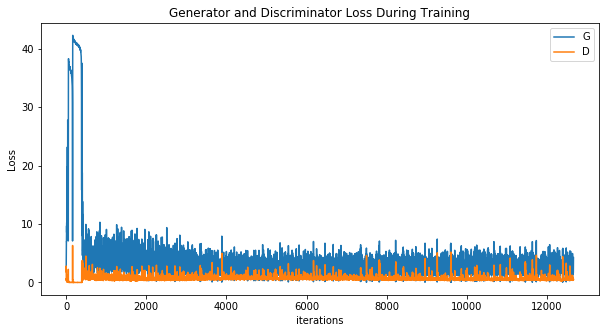

In [29]:
plt.figure(figsize=(10,5))
plt.title("Generator and Discriminator Loss During Training")
plt.plot(G_losses,label="G")
plt.plot(D_losses,label="D")
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.legend()
plt.show()

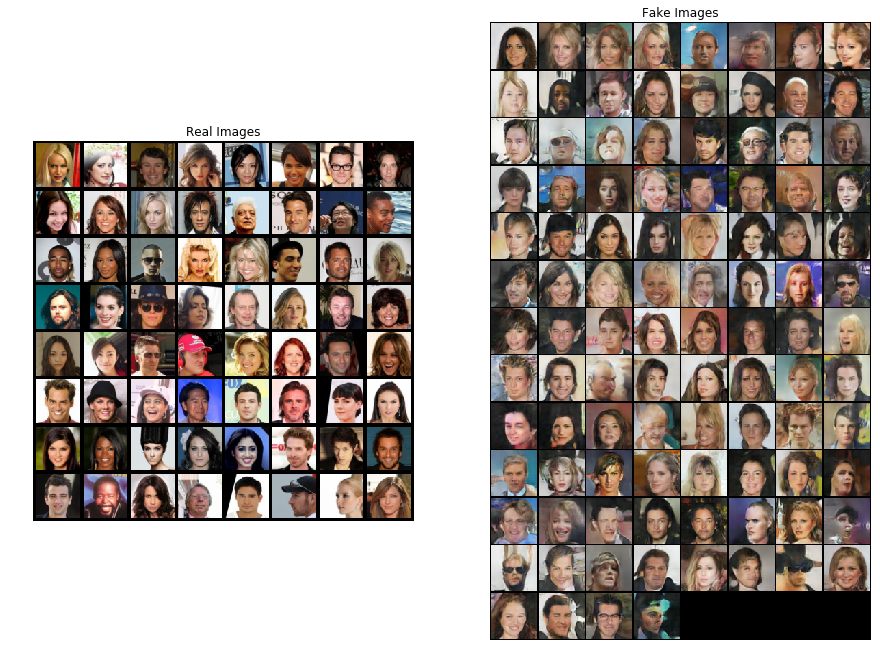

In [31]:
# Grab a batch of real images from the dataloader
real_batch = next(iter(dataloader))

# Plot the real images
plt.figure(figsize=(15,15))
plt.subplot(1,2,1)
plt.axis("off")
plt.title("Real Images")
plt.imshow(np.transpose(vutils.make_grid(real_batch[0].to(device)[:64], padding=5, normalize=True).cpu(),(1,2,0)))

# Plot the fake images from the last epoch
plt.subplot(1,2,2)
plt.axis("off")
plt.title("Fake Images")
plt.imshow(np.transpose(img_list[-1],(1,2,0)))
plt.show()

### Подсчет метрики FID

In [32]:
fixed_noise = torch.randn(img_count, nz, 1, 1, device=device)

with torch.no_grad():
    fake = netG(fixed_noise).detach().cpu()
    
results = np.array(fake)
results = np.transpose(results,(0,3,2,1))
results = results.astype('float32')
results = scale_images(results, (75,75,3))
results = preprocess_input(results)

In [33]:
fixed_noise = torch.randn(nz, 1, 1, device=device)

noise=torch.empty(img_count, nz, 1, 1, device=device)

for i in range(img_count):
    noise[i]=fixed_noise
    
with torch.no_grad():
    fake = netG(noise).detach().cpu()
    
results_1 = np.array(fake)
results_1 = np.transpose(results_1,(0,3,2,1))
results_1 = results.astype('float32')
results_1 = scale_images(results_1, (75,75,3))
results_1 = preprocess_input(results_1)

In [34]:
fid_1 = calculate_fid(model, results_1, real_imgs)

fid_res = calculate_fid(model, results, real_imgs)

fid_real = calculate_fid(model, real_imgs, real_imgs)

In [35]:
print('Epoch FIDs: ', fids)
print('FID real VS one image: %.3f' % fid_1)
print('FID real VS model results: %.3f' % fid_res)
print('FID real VS real: %.3f' % fid_real)

Epoch FIDs:  [90.68508773774288, 55.74640439363712, 45.38786079535757, 43.03513931964102, 43.28368955984612, 44.936544734778415, 41.657579934405305, 66.39829841299469]
FID real VS one image: 422.877
FID real VS model results: 113.491
FID real VS real: -0.000


### Выбор метода восстановления фотографии

#### Первый способ: восстановление картинки с помощью приближения латентного вектора

#### Пример из обучающей выборки

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Text(0.5,1,'Real Image')

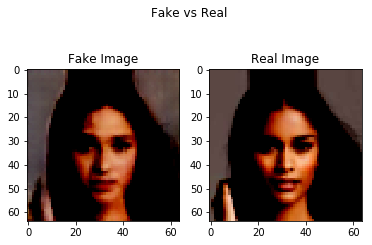

In [85]:
epochs=1000

criterion = torch.nn.MSELoss()
R=real_img[100][99]
R=torch.tensor(R, requires_grad=True).cuda()
noise = torch.randn(128, nz, 1, 1, device=device, requires_grad=True)
optimizer = torch.optim.Adam([noise], lr=0.05)
a=0.01

for epoch in range(epochs):
    P=netG(noise)
    D=netD(P)
    P=P[99]
    loss=(1-a)*criterion(P,R)+a*(1-D[99][0][0][0])
    #loss=criterion(P,R)
    loss.backward()
    optimizer.step()
    optimizer.zero_grad()
    
fig, (ax1, ax2) = plt.subplots(1, 2)
fig.suptitle('Fake vs Real')
ax1.imshow(torch.transpose(torch.transpose(P, 0, 1),1,2).cpu().detach().numpy())
ax1.set_title('Fake Image')
ax2.imshow(torch.transpose(torch.transpose(R, 0, 1),1,2).cpu().detach().numpy())
ax2.set_title('Real Image')

In [86]:
print('MSE real VS fake: %.3f' % loss)
print('Discriminator for fake: %.3f' % D[99][0][0][0])

MSE real VS fake: 0.014
Discriminator for fake: 0.986


#### Пример из тестовой выборки

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  """
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Text(0.5,1,'Real Image')

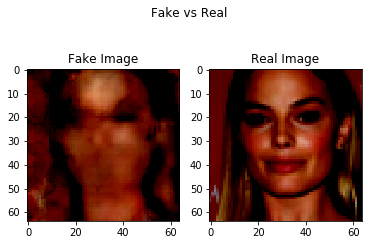

In [344]:
epochs=1000

criterion = torch.nn.MSELoss()
R=tests[4]
R=torch.tensor(R, requires_grad=True).cuda()
noise = torch.randn(128, nz, 1, 1, device=device, requires_grad=True)
optimizer = torch.optim.Adam([noise], lr=0.05)
a=0.00

for epoch in range(epochs):
    P=netG(noise)
    D=netD(P)
    P=P[0]
    loss=(1-a)*criterion(P,R)+a*(1-D[0][0][0][0])
    #loss=criterion(P,R)
    loss.backward()
    optimizer.step()
    optimizer.zero_grad()
    
fig, (ax1, ax2) = plt.subplots(1, 2)
fig.suptitle('Fake vs Real')
ax1.imshow(torch.transpose(torch.transpose(P, 0, 1),1,2).cpu().detach().numpy())
ax1.set_title('Fake Image')
ax2.imshow(torch.transpose(torch.transpose(R, 0, 1),1,2).cpu().detach().numpy())
ax2.set_title('Real Image')

In [345]:
print('MSE real VS fake: %.3f' % loss)
print('Discriminator for fake: %.3f' % D[0][0][0][0])

MSE real VS fake: 0.026
Discriminator for fake: 0.005


#### Второй способ: восстановление картинки с помощью обчуения сверточной сети.
#### В качестве метрики используется MSE между двумя фотографиями

#### Пример из обучающей выборки

In [247]:
class Vector(nn.Module):
    def __init__(self,ngpu):
        self.ngpu = ngpu
        super(Vector, self).__init__()
        self.ngpu = ngpu
        self.main = nn.Sequential(
            nn.BatchNorm2d(3),
            nn.Conv2d(3, 32, kernel_size=5, stride=3),
            nn.ReLU(True),
            
            nn.BatchNorm2d(32),
            nn.Conv2d(32, 10, kernel_size=5, stride=3),
            nn.ReLU(True),
            
            nn.BatchNorm2d(10),
            nn.Conv2d(10, 100, kernel_size=5, stride=3),
            nn.ReLU(True),
                       
            nn.Tanh()
        )

    def forward(self, input):
        return self.main(input)

In [248]:
# Decide which device we want to run on
device = torch.device("cuda:0" if (torch.cuda.is_available() and ngpu > 0) else "cpu")

In [249]:
netV = Vector(ngpu).to(device)

# Handle multi-gpu if desired
if (device.type == 'cuda') and (ngpu > 1):
    netG = nn.DataParallel(netV, list(range(ngpu)))


# Print the model
print(netV)

Vector(
  (main): Sequential(
    (0): BatchNorm2d(3, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (1): Conv2d(3, 32, kernel_size=(5, 5), stride=(3, 3))
    (2): ReLU(inplace=True)
    (3): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): Conv2d(32, 10, kernel_size=(5, 5), stride=(3, 3))
    (5): ReLU(inplace=True)
    (6): BatchNorm2d(10, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): Conv2d(10, 100, kernel_size=(5, 5), stride=(3, 3))
    (8): ReLU(inplace=True)
    (9): Tanh()
  )
)


In [250]:
num_epochs=5
random_noise = torch.randn(len(real_img), batch_size, nz, 1, 1, device=device)
criterion = torch.nn.MSELoss()
optimizer = torch.optim.Adam(netV.parameters(), lr=0.05)

In [251]:
# For each epoch
for epoch in tqdm(range(num_epochs)):
    # For each batch in the dataloader
    for i, data in enumerate(dataloader, 0):
        real = data[0].cuda()
        output = netV(real)
        fake=netG(output)
        D=netD(fake)
        loss=(1-a)*criterion(fake,real)+a*(128-torch.sum(D))
        #loss=criterion(fake,real)
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        iters += 1




  0%|          | 0/5 [00:00<?, ?it/s]


 20%|██        | 1/5 [05:27<21:49, 327.42s/it]


 40%|████      | 2/5 [10:55<16:23, 327.89s/it]


 60%|██████    | 3/5 [16:23<10:55, 327.92s/it]


 80%|████████  | 4/5 [21:52<05:28, 328.02s/it]


100%|██████████| 5/5 [27:21<00:00, 328.26s/it]




In [261]:
R=torch.tensor(real_img[100]).cuda()
F=netG(netV(R))[99]
R=R[99]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Text(0.5,1,'Real Image')

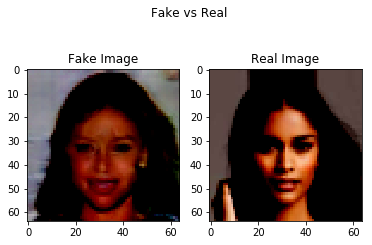

In [262]:
fig, (ax1, ax2) = plt.subplots(1, 2)
fig.suptitle('Fake vs Real')
ax1.imshow(torch.transpose(torch.transpose(F, 0, 1),1,2).cpu().detach().numpy())
ax1.set_title('Fake Image')
ax2.imshow(torch.transpose(torch.transpose(R, 0, 1),1,2).cpu().detach().numpy())
ax2.set_title('Real Image')

In [263]:
R=torch.tensor(real_img[22]).cuda()

In [264]:
D=netD(netG(netV(R)))[99]

In [265]:
print('MSE real VS one image: %.3f' % loss)
print('Discriminator for fake: %.3f' % D)

MSE real VS one image: 0.583
Discriminator for fake: 0.966


#### Пример из тестовой выборки

In [276]:
R=tests.cuda()
F=netG(netV(R))[4]
R=tests[4]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Text(0.5,1,'Real Image')

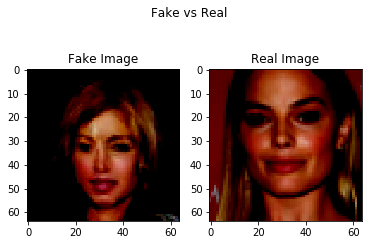

In [277]:
fig, (ax1, ax2) = plt.subplots(1, 2)
fig.suptitle('Fake vs Real')
ax1.imshow(torch.transpose(torch.transpose(F, 0, 1),1,2).cpu().detach().numpy())
ax1.set_title('Fake Image')
ax2.imshow(torch.transpose(torch.transpose(R, 0, 1),1,2).cpu().detach().numpy())
ax2.set_title('Real Image')

In [278]:
R=torch.tensor(tests).cuda()
D=netD(netG(netV(R)))[3]
loss=criterion(F,R)
print('MSE real VS one image: %.3f' % loss)
print('Discriminator for fake: %.3f' % D)

MSE real VS one image: 0.491
Discriminator for fake: 0.955


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  """Entry point for launching an IPython kernel.


#### Третий способ: восстановление картинки с помощью обчуения сверточной сети.
#### В качестве метрики используется MSE между двумя латентными векторами

#### Пример из обучающей выборки

In [352]:
class Vector(nn.Module):
    def __init__(self,ngpu):
        self.ngpu = ngpu
        super(Vector, self).__init__()
        self.ngpu = ngpu
        self.main = nn.Sequential(
            nn.BatchNorm2d(3),
            nn.Conv2d(3, 32, kernel_size=5, stride=3),
            nn.ReLU(True),
            
            nn.BatchNorm2d(32),
            nn.Conv2d(32, 10, kernel_size=5, stride=3),
            nn.ReLU(True),
            
            nn.BatchNorm2d(10),
            nn.Conv2d(10, 100, kernel_size=5, stride=3),
            nn.ReLU(True),
                       
            nn.Tanh()
        )

    def forward(self, input):
        return self.main(input)

In [353]:
netV2 = Vector(ngpu).to(device)

# Handle multi-gpu if desired
if (device.type == 'cuda') and (ngpu > 1):
    netV2 = nn.DataParallel(netV2, list(range(ngpu)))


# Print the model
print(netV2)

Vector(
  (main): Sequential(
    (0): BatchNorm2d(3, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (1): Conv2d(3, 32, kernel_size=(5, 5), stride=(3, 3))
    (2): ReLU(inplace=True)
    (3): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): Conv2d(32, 10, kernel_size=(5, 5), stride=(3, 3))
    (5): ReLU(inplace=True)
    (6): BatchNorm2d(10, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): Conv2d(10, 100, kernel_size=(5, 5), stride=(3, 3))
    (8): ReLU(inplace=True)
    (9): Tanh()
  )
)


In [354]:
num_epochs=5
random_noise = torch.randn(len(real_img), batch_size, nz, 1, 1, device=device)
criterion = torch.nn.MSELoss()
optimizer = torch.optim.Adam(netV2.parameters(), lr=0.05)

In [355]:
loss=10

In [356]:
losses=[]

In [357]:
# For each epoch
for epoch in tqdm(range(num_epochs)):
    while loss>0.02:
        random_noise = torch.randn(batch_size, nz, 1, 1, device=device)
        pics=netG(random_noise)
        output = netV2(pics)  
        rn=random_noise.cuda()
        loss=criterion(rn,output)
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        losses.append(loss)
        print(loss)





  0%|          | 0/5 [00:00<?, ?it/s]

tensor(1.1115, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(1.1468, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(1.0281, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(1.0103, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.9969, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(1.0244, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(1.0208, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(1.0237, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(1.0169, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(1.0215, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.9951, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(1.0066, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.9773, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(1.0278, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(1.0204, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(1.0058, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.9850, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.9979, device='cuda:0',

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



tensor(1.0128, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.9954, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(1.0227, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.9938, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(1.0048, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(1.0025, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.9823, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(1.0119, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.9959, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(1.0155, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(1.0214, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(1.0047, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.9994, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(1.0123, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(1.0406, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(1.0007, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.9907, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.9968, device='cuda:0',

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



tensor(0.9978, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(1.0199, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.9982, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(1.0114, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.9986, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(1.0024, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(1.0280, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.9888, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(1.0396, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(1.0139, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(1.0330, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.9912, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(1.0224, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(1.0267, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.9974, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.9986, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(1.0107, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.9978, device='cuda:0',

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



tensor(1.0197, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(1.0175, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.9914, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(1.0033, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(1.0160, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(1.0090, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(1.0384, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(1.0302, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(1.0001, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(1.0185, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(1.0128, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(1.0039, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.9925, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(1.0318, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(1.0201, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.9856, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(1.0071, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.9959, device='cuda:0',

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



tensor(0.9952, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.9915, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.9991, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(1.0143, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(1.0203, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(1.0220, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(1.0100, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.9956, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(1.0231, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.9814, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.9824, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(1.0242, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.9908, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(1.0273, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(1.0394, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(1.0199, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(1.0024, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(1.0441, device='cuda:0',

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



tensor(1.0254, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(1.0170, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(1.0218, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(1.0067, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.9942, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.9991, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(1.0111, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(1.0447, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.9959, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(1.0015, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(1.0083, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(1.0096, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(1.0100, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(1.0253, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.9878, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(1.0264, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(1.0152, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(1.0460, device='cuda:0',

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



tensor(1.0235, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(1.0157, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.9771, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(1.0240, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(1.0235, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(1.0092, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(1.0197, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.9979, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(1.0320, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.9842, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.9969, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(1.0170, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.9940, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(1.0005, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(1.0249, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.9938, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(1.0150, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(1.0201, device='cuda:0',

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



tensor(0.9971, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(1.0094, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(1.0283, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(1.0186, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.9945, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(1.0199, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.9948, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.9988, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(1.0182, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(1.0005, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.9823, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(1.0151, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(1.0054, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(1.0018, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(1.0214, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(1.0193, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.9963, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(1.0130, device='cuda:0',

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



tensor(1.0172, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.9768, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(1.0430, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(1.0112, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.9910, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(1.0243, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(1.0093, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(1.0089, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.9972, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(1.0088, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.9925, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(1.0221, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.9954, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(1.0064, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(1.0024, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(1.0204, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(1.0193, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.9991, device='cuda:0',

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



tensor(1.0067, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(1.0056, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(1.0136, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(1.0066, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(1.0176, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(1.0250, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.9870, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(1.0241, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.9944, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(1.0002, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(1.0120, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(1.0041, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(1.0224, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(1.0135, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(1.0318, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(1.0195, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(1.0154, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(1.0063, device='cuda:0',

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



tensor(1.0207, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(1.0192, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(1.0200, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(1.0048, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(1.0079, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(1.0049, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(1.0055, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(1.0276, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.9943, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(1.0107, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.9944, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(1.0011, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(1.0024, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(1.0036, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(1.0103, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(1.0031, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(1.0336, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(1.0181, device='cuda:0',

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



tensor(1.0103, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(1.0191, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(1.0090, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(1.0129, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(1.0037, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(1.0003, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.9914, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(1.0229, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.9905, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(1.0039, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.9905, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(1.0095, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(1.0046, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.9950, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(1.0121, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(1.0034, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.9925, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(1.0037, device='cuda:0',

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



tensor(1.0188, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.9999, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(1.0313, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(1.0084, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(1.0213, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.9999, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(1.0064, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(1.0030, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(1.0056, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.9932, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(1.0139, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(1.0134, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(1.0165, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(1.0231, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.9904, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.9928, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(1.0226, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(1.0042, device='cuda:0',

KeyboardInterrupt: 

In [33]:
R=torch.tensor(real_img[100]).cuda()
F=netG(netV2(R))[99]
R=R[99]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Text(0.5,1,'Real Image')

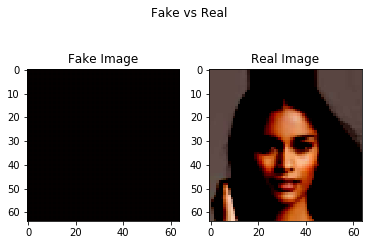

In [34]:
fig, (ax1, ax2) = plt.subplots(1, 2)
fig.suptitle('Fake vs Real')
ax1.imshow(torch.transpose(torch.transpose(F, 0, 1),1,2).cpu().detach().numpy())
ax1.set_title('Fake Image')
ax2.imshow(torch.transpose(torch.transpose(R, 0, 1),1,2).cpu().detach().numpy())
ax2.set_title('Real Image')

In [257]:
loss=criterion(F,R)

In [252]:
R=torch.tensor(real_img[100]).cuda()
D=netD(netG(netV2(R)))[99]

In [258]:
print('MSE real VS one image: %.3f' % loss)
print('Discriminator for fake: %.3f' % D)

MSE real VS one image: 0.453
Discriminator for fake: 0.000


#### Пример из тестовой выборки

In [64]:
R=pic.cuda()
F=netG(netV2(R))[0]
R=R[0]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Text(0.5,1,'Real Image')

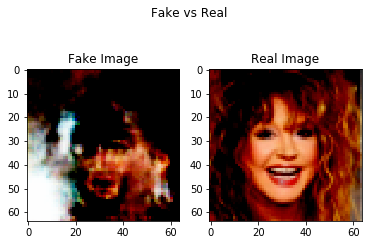

In [130]:
fig, (ax1, ax2) = plt.subplots(1, 2)
fig.suptitle('Fake vs Real')
ax1.imshow(torch.transpose(torch.transpose(F, 0, 1),1,2).cpu().detach().numpy())
ax1.set_title('Fake Image')
ax2.imshow(torch.transpose(torch.transpose(R, 0, 1),1,2).cpu().detach().numpy())
ax2.set_title('Real Image')

### Восстановление картинки

In [116]:
def filter_fake(a,b):
    filt=torch.empty(3, 64, 64, device=device)
    for i in range(3):
        for j in range(64):
            for z in range(64):
                if (j>a and z>b):
                    filt[i][j][z]=0
                else:
                    filt[i][j][z]=1
    return filt

In [117]:
def filter_real(a,b):
    filt=torch.empty(3, 64, 64, device=device)
    for i in range(3):
        for j in range(64):
            for z in range(64):
                if (j>a and z>b):
                    filt[i][j][z]=1
                else:
                    filt[i][j][z]=0
    return filt

In [118]:
filt_real=filter_real(45,0)

In [119]:
filt_fake=filter_fake(45,0)

### Фотография из обучающей выборки

#### Первая модель

In [191]:
epochs=1000
criterion = torch.nn.MSELoss()
R=real_img[100][99]
R=torch.tensor(R, requires_grad=True).cuda()
R_new=R*filt_fake
R_new=torch.tensor(R_new, requires_grad=True).cuda()
noise = torch.randn(128, nz, 1, 1, device=device, requires_grad=True)
optimizer = torch.optim.Adam([noise], lr=0.05)
a=0.01

for epoch in range(epochs):
    P=netG(noise)
    D=netD(P)
    P=P[99]
    Pl=P*filt_fake
    loss=(1-a)*criterion(Pl,R_new)+a*(1-D[0][0][0])
    loss.backward()
    optimizer.step()
    optimizer.zero_grad()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  


In [192]:
P_filt=P*filt_real+R_new

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Text(0.5,1,'Mix Image')

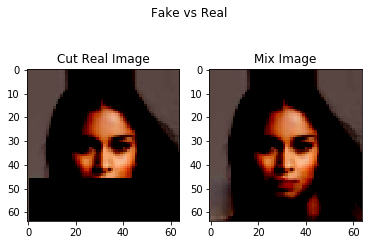

In [193]:
fig, (ax1, ax2) = plt.subplots(1, 2)
fig.suptitle('Fake vs Real')
ax1.imshow(torch.transpose(torch.transpose(R_new, 0, 1),1,2).cpu().detach().numpy())
ax1.set_title('Cut Real Image')
ax2.imshow(torch.transpose(torch.transpose(P_filt, 0, 1),1,2).cpu().detach().numpy())
ax2.set_title('Mix Image')

In [194]:

print('MSE real VS one image: %.3f' % loss)
print('Discriminator for fake: %.3f' % D[0][0][0])

MSE real VS one image: 0.005
Discriminator for fake: 1.000


#### Вторая модель

In [279]:
def filter_fake_3d(a,b):
    filt=torch.empty(128, 3, 64, 64, device=device)
    for d in range(128):
        for i in range(3):
            for j in range(64):
                for z in range(64):
                    if (j>a and z>b):
                        filt[d][i][j][z]=0
                    else:
                        filt[d][i][j][z]=1
    return filt

In [280]:
def filter_real_3d(a,b):
    filt=torch.empty(128, 3, 64, 64, device=device)
    for d in range(128):
        for i in range(3):
            for j in range(64):
                for z in range(64):
                    if (j>a and z>b):
                        filt[d][i][j][z]=1
                    else:
                        filt[d][i][j][z]=0
    return filt

In [281]:
filt_real_3d=filter_real_3d(45,0)

In [282]:
filt_fake_3d=filter_fake_3d(45,0)

In [283]:
R=real_img[100]
R=torch.tensor(R, requires_grad=True).cuda()
R_new=R*filt_fake_3d
R_new=torch.tensor(R_new, requires_grad=True).cuda()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  after removing the cwd from sys.path.


In [284]:
P=netG(netV(R_new))

In [285]:
P_filt=P*filt_real+R_new

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Text(0.5,1,'Mix Image')

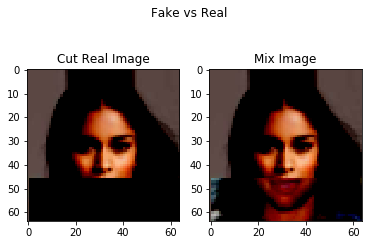

In [286]:
fig, (ax1, ax2) = plt.subplots(1, 2)
fig.suptitle('Fake vs Real')
ax1.imshow(torch.transpose(torch.transpose(R_new[99], 0, 1),1,2).cpu().detach().numpy())
ax1.set_title('Cut Real Image')
ax2.imshow(torch.transpose(torch.transpose(P_filt[99], 0, 1),1,2).cpu().detach().numpy())
ax2.set_title('Mix Image')

In [287]:
D=netD(P_filt)[99]
loss=criterion(P_filt[99],R[99])
print('MSE real VS one image: %.3f' % loss)
print('Discriminator for fake: %.3f' % D)

MSE real VS one image: 0.075
Discriminator for fake: 0.343


#### Тестовая выборка

In [296]:
R=tests.cuda()
R=torch.tensor(R, requires_grad=True).cuda()
R_new=R*filt_fake_3d[:9]
R_new=torch.tensor(R_new, requires_grad=True).cuda()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  after removing the cwd from sys.path.


In [297]:
P=netG(netV(R_new))
P_filt=P*filt_real+R_new

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Text(0.5,1,'Mix Image')

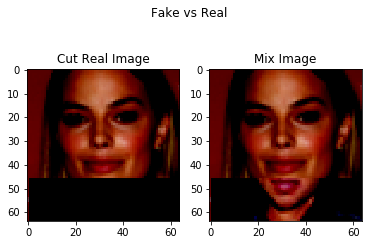

In [312]:
fig, (ax1, ax2) = plt.subplots(1, 2)
fig.suptitle('Fake vs Real')
ax1.imshow(torch.transpose(torch.transpose(R_new[4], 0, 1),1,2).cpu().detach().numpy())
ax1.set_title('Cut Real Image')
ax2.imshow(torch.transpose(torch.transpose(P_filt[4], 0, 1),1,2).cpu().detach().numpy())
ax2.set_title('Mix Image')

In [313]:
D=netD(P_filt)[4]
loss=criterion(P_filt[4],R[4])
print('MSE real VS one image: %.3f' % loss)
print('Discriminator for fake: %.3f' % D)

MSE real VS one image: 0.101
Discriminator for fake: 0.049


### Удаление водяного знака

#### Первая модель

In [177]:
def mask_fake():
    filt=torch.empty(3, 64, 64, device=device)
    for i in range(3):
        for j in range(64):
            for z in range(64):
                if (j==z or j==64-z):
                    filt[i][j][z]=0
                else:
                    filt[i][j][z]=1
    return filt

In [178]:
mask=mask_fake()

In [185]:
epochs=1000
criterion = torch.nn.MSELoss()
R=real_img[20][99]
R=torch.tensor(R, requires_grad=True).cuda()
R_new=R*mask
R_new=torch.tensor(R_new, requires_grad=True).cuda()
noise = torch.randn(128, nz, 1, 1, device=device, requires_grad=True)
optimizer = torch.optim.Adam([noise], lr=0.05)
a=0.01

for epoch in range(epochs):
    P=netG(noise)
    D=netD(P)
    P=P[99]
    Pl=P*mask
    loss=(1-a)*criterion(Pl,R_new)+a*(1-D[0][0][0])
    loss.backward()
    optimizer.step()
    optimizer.zero_grad()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Text(0.5,1,'Recover Image')

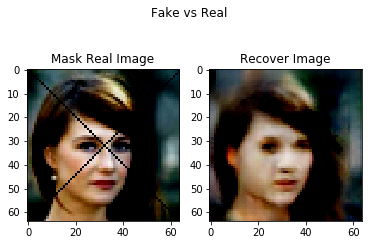

In [186]:
fig, (ax1, ax2) = plt.subplots(1, 2)
fig.suptitle('Fake vs Real')
ax1.imshow(torch.transpose(torch.transpose(R_new, 0, 1),1,2).cpu().detach().numpy())
ax1.set_title('Mask Real Image')
ax2.imshow(torch.transpose(torch.transpose(P, 0, 1),1,2).cpu().detach().numpy())
ax2.set_title('Recover Image')

In [184]:
loss=criterion(P,R)
print('MSE real VS one image: %.3f' % loss)
print('Discriminator for fake: %.3f' % D[0][0][0])

MSE real VS one image: 0.012
Discriminator for fake: 1.000


#### Вторая модель

#### Обучающая выборка

In [314]:
def filter_fake_3d():
    filt=torch.empty(128, 3, 64, 64, device=device)
    for d in range(128):
        for i in range(3):
            for j in range(64):
                for z in range(64):
                    if (j==z):
                        filt[d][i][j][z]=0
                    else:
                        filt[d][i][j][z]=1
    return filt

In [316]:
def filter_real_3d():
    filt=torch.empty(128, 3, 64, 64, device=device)
    for d in range(128):
        for i in range(3):
            for j in range(64):
                for z in range(64):
                    if (j==z):
                        filt[d][i][j][z]=1
                    else:
                        filt[d][i][j][z]=0
    return filt

In [319]:
filt_real_3d=filter_real_3d()

In [320]:
filt_fake_3d=filter_fake_3d()

In [335]:
R=real_img[100]
R=torch.tensor(R, requires_grad=True).cuda()
R_new=R*filt_fake_3d
R_new=torch.tensor(R_new, requires_grad=True).cuda()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  after removing the cwd from sys.path.


In [336]:
P=netG(netV(R_new))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Text(0.5,1,'Recover Image')

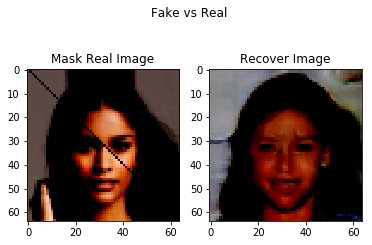

In [337]:
fig, (ax1, ax2) = plt.subplots(1, 2)
fig.suptitle('Fake vs Real')
ax1.imshow(torch.transpose(torch.transpose(R_new[99], 0, 1),1,2).cpu().detach().numpy())
ax1.set_title('Mask Real Image')
ax2.imshow(torch.transpose(torch.transpose(P[99], 0, 1),1,2).cpu().detach().numpy())
ax2.set_title('Recover Image')

In [339]:
loss=criterion(R_new[99],P[99])
print('MSE real VS one image: %.3f' % loss)
print('Discriminator for fake: %.3f' % D[0][0][0])

MSE real VS one image: 0.238
Discriminator for fake: 0.049


#### Тестовая выборка

In [327]:
R=tests.cuda()
R=torch.tensor(R, requires_grad=True).cuda()
R_new=R*filt_fake_3d[:9]
R_new=torch.tensor(R_new, requires_grad=True).cuda()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  after removing the cwd from sys.path.


In [328]:
P=netG(netV(R_new))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Text(0.5,1,'Recover Image')

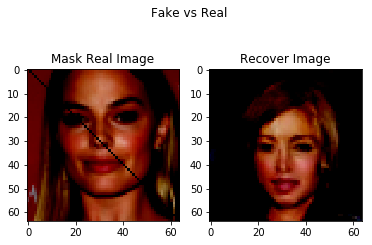

In [332]:
fig, (ax1, ax2) = plt.subplots(1, 2)
fig.suptitle('Fake vs Real')
ax1.imshow(torch.transpose(torch.transpose(R_new[4], 0, 1),1,2).cpu().detach().numpy())
ax1.set_title('Mask Real Image')
ax2.imshow(torch.transpose(torch.transpose(P[4], 0, 1),1,2).cpu().detach().numpy())
ax2.set_title('Recover Image')

In [333]:
loss=criterion(R_new[4],P[4])
print('MSE real VS one image: %.3f' % loss)
print('Discriminator for fake: %.3f' % D[0][0][0])

MSE real VS one image: 0.241
Discriminator for fake: 0.049
